# Problem 3

## Part A

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

def AlternativeChungLu(degs):
    edge_list = []
    K = sum(degs)
    M = np.random.poisson(K/2)
    n = len(degs)
    weights = weights=degs/sum(degs)
    
    for _ in range(M):
        i = random.choices(range(n), weights=weights, k=1)[0]
        j = random.choices(range(n), weights=weights, k=1)[0]
        edge_list.append((i, j))
    return edge_list

## Part B

In [2]:
def ChungLu(degs):
    n = len(degs)
    edge_list = []
    deg_sum = sum(degs)

    for i in range(n):
        for j in range(i, n):
            mean_edges = (degs[i] * degs[j]) / deg_sum
            num_edges = np.random.poisson(mean_edges)

            for _ in range(num_edges):
                edge_list.append((i, j))
    return edge_list

## Part C

In [3]:
import time

ns = [10, 15, 25, 50, 75, 100, 250, 500, 750, 1000, 1500, 2000, 4000]
CLTimes = []
ACLTimes = []

for n in ns:
    in_degs = np.random.randint(1, 10, size=n)

    start = time.time()
    ChungLu(in_degs)
    end = time.time()
    CLTimes.append(end - start)

    start = time.time()
    AlternativeChungLu(in_degs)
    end = time.time()
    ACLTimes.append(end - start)

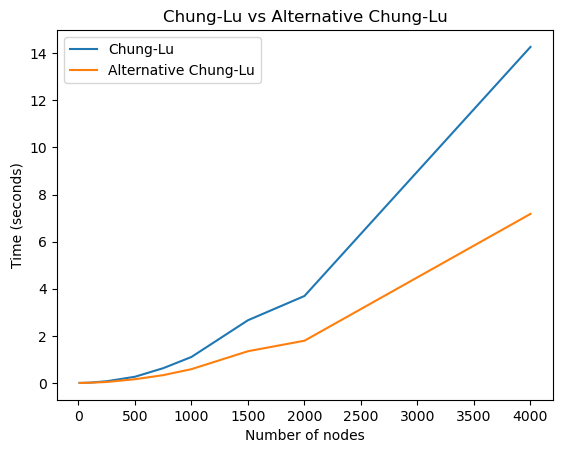

In [4]:
plt.plot(ns, CLTimes, label='Chung-Lu')
plt.plot(ns, ACLTimes, label='Alternative Chung-Lu')
plt.xlabel('Number of nodes')
plt.ylabel('Time (seconds)')
plt.title('Chung-Lu vs Alternative Chung-Lu')
plt.legend()

The Alternative Chung-Lu algorithm seems like a much faster method for very large n.

# Problem 6

## Part A

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time

def OptimizedPreferentialAttachment(n_steps, alpha):
    
    # Start w/ 2 nodes and in hypothetical scenario we add 1 node at every step, gives us this max possibility
    # all nodes start with degree zero for all possible nodes (except for the first two ones attached to each other; these have degree 1)
    max_nodes = n_steps + 2
    degrees = np.zeros(max_nodes, dtype=int)
    degrees[0:2] = 1

    # Hold nodes w/ multiplcity of their degree which allows uniform sampling;
    # size is safe enough? TODO CHECK: add 2 nodes per step is max 2*n_steps + 2?
    repeated_nodes = np.zeros(2 *max_nodes, dtype=int)
    repeated_nodes[0:2] = [0, 1]
    cur_rep = 2

    # Preallocated edges array with 2 for u, v and n_steps for the number of edges max
    edges = np.zeros((n_steps, 2), dtype=int)

    # One key optim. is that we can perform uniform sampl. from the repeated nodes rather 
    # than degree proportional sampling, so we don't need to recompute degrees weighting at each t!
    for step in range(n_steps):
        if np.random.rand() < alpha:
            u = repeated_nodes[np.random.randint(cur_rep)]
        else:
            u = np.random.randint(step +2)
        v = step + 2
        edges[step] = [u, v]
        degrees[u] += 1
        degrees[v] = 1

        # add nodes to repeated nodes list and increment position
        repeated_nodes[cur_rep:cur_rep+2] = [u, v]
        cur_rep += 2

    G = nx.Graph()
    G.add_edges_from(edges)
    return G

## Part B

In [2]:
# CODE SOURCED FROM LECTURE NOTES AND ADAPTED TO FUNCTION: https://network-science-notes.github.io/chapters/120-preferential-attachment.html#the-preferential-attachment-model-a-generative-model-for-power-law-degrees
def SlowPreferentialAttachment(alpha, n_steps):
    G = nx.Graph() 
    G.add_edge(0, 1) 

    # main loop
    for _ in range(n_steps):
        degrees = nx.degree(G)

        # determine u using one of two mechanisms
        if np.random.rand() < alpha: 
            deg_seq = np.array([deg[1] for deg in degrees])
            degree_weights = deg_seq / deg_seq.sum()
            u = np.random.choice(np.arange(len(degrees)), p = degree_weights)
        else: 
            u = np.random.choice(np.arange(len(degrees)))

        # integer index of new node v
        v = len(degrees)

        # add new edge to graph    
        G.add_edge(u, v)
    return G

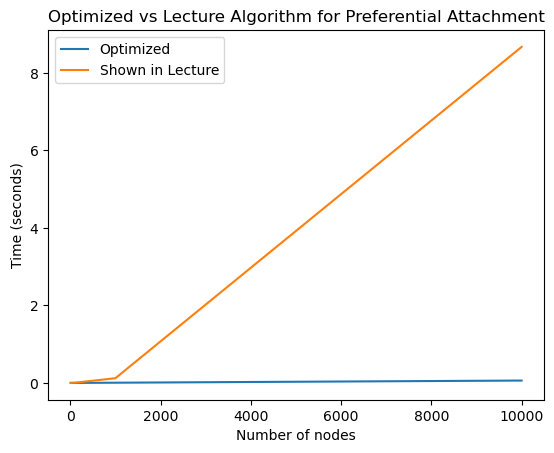

In [8]:
alpha = 4/5
hs = [1, 2, 3, 4]
ns = [10 ** h for h in hs]
optimized_times = []
slow_times = []

for n in ns:
    start = time.time()
    OptimizedPreferentialAttachment(n_steps=n, alpha=alpha)
    end = time.time()
    optimized_times.append(end - start)

    start = time.time()
    SlowPreferentialAttachment(alpha=alpha, n_steps=n)
    end = time.time()
    slow_times.append(end - start)

plt.plot(ns, optimized_times, label='Optimized')
plt.plot(ns, slow_times, label='Shown in Lecture')
plt.xlabel('Number of nodes')
plt.ylabel('Time (seconds)')
plt.title('Optimized vs Lecture Algorithm for Preferential Attachment')
plt.legend()

## Part C

In [19]:
# THIS CODE IS SOURCED FROM LECTURE NOTES: https://network-science-notes.github.io/chapters/120-preferential-attachment.html#the-preferential-attachment-model-a-generative-model-for-power-law-degrees
def degree_sequence(G):
    degrees = nx.degree(G)
    degree_sequence = np.array([deg[1] for deg in degrees])
    return degree_sequence

def log_binned_histogram(degree_sequence, interval = 5, num_bins = 20):
    hist, bins = np.histogram(degree_sequence, bins = min(int(len(degree_sequence)/interval), num_bins))
    bins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    hist, bins = np.histogram(degree_sequence, bins = bins)
    binwidths = bins[1:] - bins[:-1]
    hist = hist / binwidths
    p = hist/hist.sum()

    return bins[:-1], p

def plot_degree_distribution(G, **kwargs):

    deg_seq = degree_sequence(G)
    x, p = log_binned_histogram(deg_seq, **kwargs)
    plt.scatter(x, p,  facecolors='none', edgecolors =  'cornflowerblue', linewidth = 2, label = "Data")
    plt.gca().set(xlabel = "Degree", xlim = (0.5, x.max()*2))
    plt.gca().set(ylabel = "Density")
    plt.gca().loglog()
    plt.legend()
    return plt.gca()

In [23]:
n = 10 ** 6
alphas = [0.5, 0.75, 1.0]
G0 = OptimizedPreferentialAttachment(n_steps=n, alpha=alphas[0])
G1 = OptimizedPreferentialAttachment(n_steps=n, alpha=alphas[1])
G2 = OptimizedPreferentialAttachment(n_steps=n, alpha=alphas[2])
GS = [G0, G1, G2]

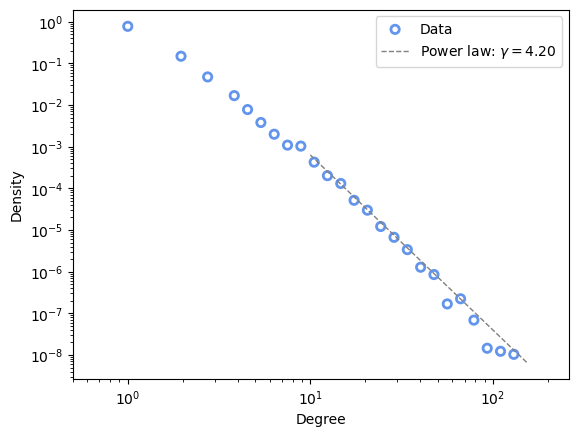

In [40]:
i = 0
deg_seq = degree_sequence(GS[i])
cutoff  = 10
d_      = np.arange(cutoff, deg_seq.max(), 1)
gamma   = (1.6 + alphas[i]) / alphas[i]
power_law = 10*d_**(-gamma)

ax = plot_degree_distribution(GS[i], interval = 2, num_bins = 30)
ax.plot(d_, power_law,  linewidth = 1, label = fr"Power law: $\gamma = {gamma:.2f}$" , color = "grey", linestyle = "--")
ax.legend()

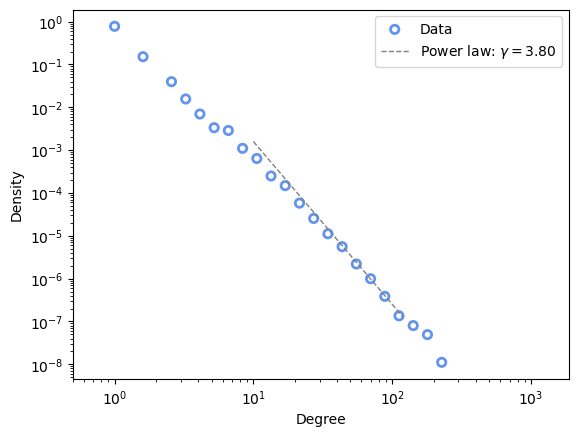

In [55]:
i = 1
deg_seq = degree_sequence(GS[i])
cutoff  = 10
d_      = np.arange(cutoff, 120, 1)
gamma   = (2.1 + alphas[i]) / alphas[i]
power_law = 10*d_**(-gamma)

ax = plot_degree_distribution(GS[i], interval = 2, num_bins = 30)
ax.plot(d_, power_law,  linewidth = 1, label = fr"Power law: $\gamma = {gamma:.2f}$" , color = "grey", linestyle = "--")
ax.legend()

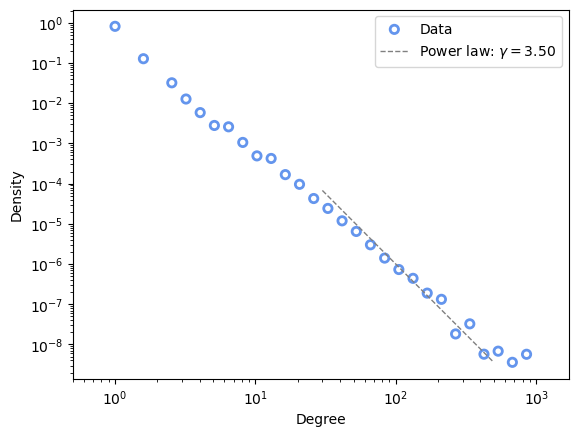

In [60]:
i = 2
deg_seq = degree_sequence(GS[i])
cutoff  = 30
d_      = np.arange(cutoff, 500, 1)
gamma   = (2.5 + alphas[i]) / alphas[i]
power_law = 10*d_**(-gamma)

ax = plot_degree_distribution(GS[i], interval = 2, num_bins = 30)
ax.plot(d_, power_law,  linewidth = 1, label = fr"Power law: $\gamma = {gamma:.2f}$" , color = "grey", linestyle = "--")
ax.legend()